In [1]:
#!pipenv install blackcellmagic --dev
#!pipenv install seaborn

In [2]:
%load_ext blackcellmagic

In [3]:
import pandas
df = pandas.read_csv("train.csv")

In [4]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [5]:
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.stats import shapiro
from sklearn.utils.multiclass import unique_labels
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from scipy.stats import probplot
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

In [18]:
class CrawtoML:
    """
    """

    def __init__(
        self, data, target, features="infer", problem="infer", imputer="most_frequent"
    ):
        self.data = data
        self.target = target
        self.nan_features = []
        self.categorical_features = []
        self.problematic_columns = []
        self.numeric_features = []
        self.imputed_columns = []
        if features == "infer":
            self.features = list(self.data.columns)
            self.features.remove(self.target)
        # TODO elif
        if problem in ["classification", "regression"]:
            self.problem = problem
        else:
            # TODO infer
            raise Exception("problem=infer not implemented")
        self.define_nan_features()
        self.imputation()
        self.define_numeric_features()
        self.define_categorical_features()
        self.column_parser()

    def define_numeric_features(self):
        numeric_features = []
        for i in self.features:
            if self.data[i].dtypes in ["int64", "float64"]:
                numeric_features.append(i)
        return numeric_features

    def define_categorical_features(self, threshold=10):
        for i in self.features:
            if len(self.data[i].value_counts()) < threshold:
                self.categorical_features.append(i)
                if i in self.numeric_features:
                    self.numeric_features.remove(i)

    def target_encoder(self):
        self.target_encoder = TargetEncoder()
        self.target_encoder
        pass

    def define_nan_features(self):
        df = pandas.DataFrame(self.data.isna().sum())
        for i in self.features:
            if df.loc[i][0] > 0:
                self.nan_features.append(i)
                self.features.remove(i)

    def imputation(self):
        # http://www.stat.columbia.edu/~gelman/arm/missing.pandasf
        # http://www.feat.engineering/imputation-methods.html#fnref74
        for i in self.nan_features:
            if self.data[i].dtype == "O":
                self.data[i] = self.data[i].astype("str")
                le = LabelEncoder()
                le.fit(self.data[i])
                le.transform(self.data[i])
                imputer = IterativeImputer()
                self.data[f"imputed_{i}"] = imputer.fit_transform(
                    le.transform(np.array(self.data[i].reshape(-1, 1)))
                )
                self.imputed_columns.append(i)
                print(i)

    def other_types(self):
        others = [i for i in self.features if i not in self.numeric_columns]
        self.other_types = others
        return self.other_types

    def column_parser(self):
        for i in self.features:
            if "Id" in i:
                self.problematic_columns.append(i)
            elif "ID" in i:
                self.problematic_columns.append(i)

    def correlation_report(self):
        seaborn.heatmap(self.data[self.numeric_features].corr())

    def target_distribution_report(self):
        if self.problem == "regression":
            print(seaborn.distplot(self.data[self.target]))
        elif self.problem == "classification":
            print(seaborn.countplot(self.data[self.target]))

    def numeric_columns_distribution_report(self):
        self.distribution_r()

    #         print(
    #             seaborn.PairGrid(
    #                 self.data, x_vars=self.numeric_columns, y_vars=self.target
    #             ).map(seaborn.distplot)
    #         )

    def distribution_r(self):
        display(
            pandas.DataFrame(
                [
                    self.distribution_fit(self.data, i)
                    for i in self.numeric_columns + [self.target]
                ],
                index=self.numeric_columns + [self.target],
            )
        )

    def distribution_fit(self, data, numeric_features):
        """
        x is a column_name
        """
        shapiro_values = shapiro(data[numeric_features])
        test_indication = True if shapiro_values[1] > 0.05 else False

        distribution_types = ["norm", "expon", "logistic", "gumbel"]
        # anderson_values = anderson(automl.data[numeric_column], dist=i)

        return {
            "Shapiro-Wilks_Test_Statistic": shapiro_values[0],
            "Shapiro-Wilks_p_Value": shapiro_values[1],
            "Normal distribution ?": test_indication
            # "Anderson_Darling_Test_Statistic_Normal": anderson_values[0][0],
        }

    def nan_report(self):
        display(
            pandas.DataFrame(
                round((self.data.isna().sum() / self.data.shape[0]) * 100, 2),
                columns=["Percent of data encoded NAN"],
            )
        )

    def correlation_report(self, threshold=0.95):
        corr_matrix = self.data[[self.target] + self.numeric_features].corr()
        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
        )
        highly_correlated_features = [
            column for column in upper.columns if any(upper[column] > threshold)
        ]
        seaborn.heatmap(corr_matrix)
        if len(highly_correlated_features) > 0:
            print(f"Highly Correlated features are {highly_correlated_features}")
        else:
            print("No Features are correlated above the threshold")

    def probability_plots(self):
        len_plots = len(self.numeric_features) / 2
        fig = plt.figure(figsize=(12, 12))
        fig.tight_layout()
        for i in range(1, len(self.numeric_features) + 1):
            fig.add_subplot(len_plots, 2, i)

            probplot(automl.data[self.numeric_features[i - 1]], plot=plt)
            plt.subplots_adjust(
                left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.35
            )
            plt.title(self.numeric_features[i - 1] + " Probability Plot")
        plt.show()

    def __repr__(self):
        return f"\tTarget Column: {self.target} \n\
        Problematic Columns: {self.problematic_columns}\n\
        Feature Columns: {self.categorical_features}\n\
        Numeric Columns: {self.numeric_features}\n\
        Imputed Columns: {self.imputed_columns}\n\
        NAN Columns:     {self.nan_features}"


#            """Saved patterns"""
#  print(seaborn.PairGrid(self.data, x_vars=self.numeric_columns, y_vars=self.target).map(
#             seaborn.boxplot
#         ))

In [19]:
automl = CrawtoML(
    data=df,
    target="Survived",
    problem='classification'
)

In [20]:
automl

	Target Column: Survived 
        Problematic Columns: ['PassengerId']
        Feature Columns: ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
        Numeric Columns: []
        Imputed Columns: []
        NAN Columns:     ['Age']

In [82]:
automl.data.Cabin.dtype

dtype('O')

In [83]:
df["Cabin"].dtype

dtype('O')

In [28]:
automl.categorical_features

['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

In [29]:
automl.probability_plots()

<Figure size 864x864 with 0 Axes>

In [30]:
automl.nan_report()

,Percent of data encoded NAN
PassengerId,0.00
Survived,0.00
Pclass,0.00
Name,0.00
Sex,0.00
Age,19.87
SibSp,0.00
Parch,0.00
Ticket,0.00
Fare,0.00


AxesSubplot(0.125,0.125;0.775x0.755)


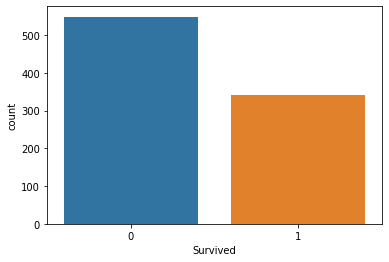

In [31]:
automl.target_distribution_report()

No Features are correlated above the threshold


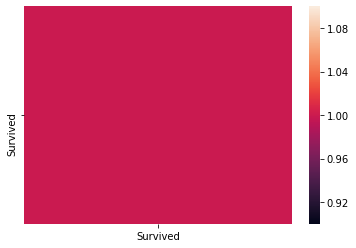

In [33]:
automl.correlation_report()

# Experiments

In [ ]:
from scipy.stats import anderson

In [ ]:
distribution_types = ['norm','expon','logistic','gumbel']

In [ ]:
l = []
for i in distribution_types:
    l.append(anderson(automl.data[automl.numeric_columns[0]], dist=i))

In [ ]:
def distribution_fit(data, numeric_column):
        from scipy.stats import shapiro

        """
        x is a column_name
        """
        shapiro_values = shapiro(data[numeric_column])
        test_indication = True if shapiro_values[1] > 0.05 else False

        distribution_types = ["norm", "expon", "logistic", "gumbel"]
        # anderson_values = anderson(automl.data[numeric_column], dist=i)

        return {
            "Shapiro_Wilks_Test_Statistic": shapiro_values[0],
            "Shapiro_Wilks_p_Value": shapiro_values[1],
            "Does the test indicate the data is normally distributed": test_indication
            # "Anderson_Darling_Test_Statistic_Normal": anderson_values[0][0],
        }

In [ ]:
distribution_fit(automl.data,automl.numeric_columns[0])

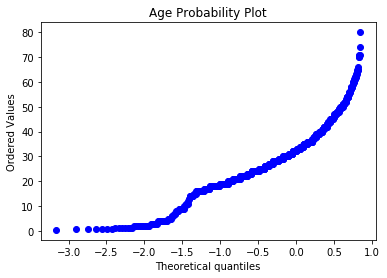

In [24]:
from scipy.stats import probplot
import matplotlib.pyplot as plt
probplot(automl.data[automl.numeric_columns[2]], plot=plt)
plt.title(automl.numeric_columns[2] + ' Probability Plot')
plt.show();

In [44]:
automl.numeric_columns

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

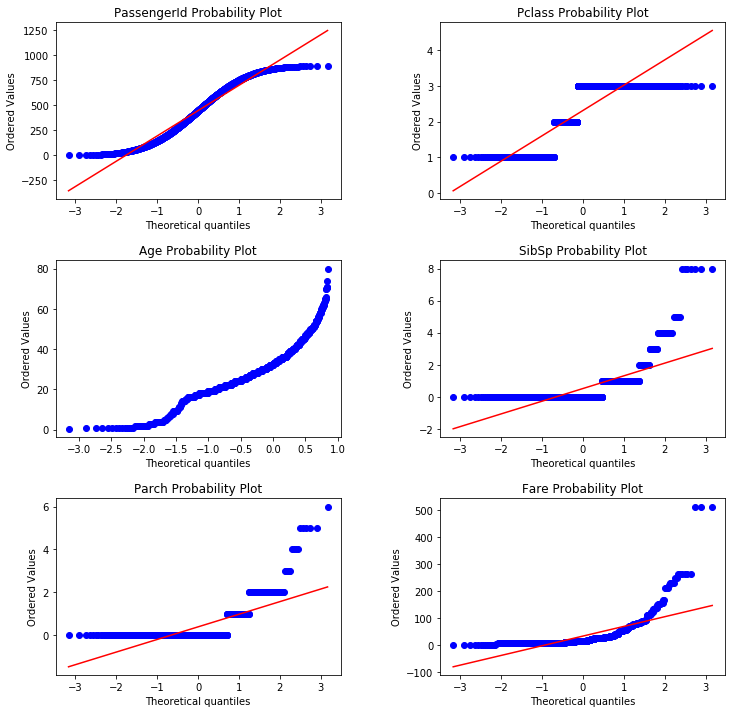

In [70]:
len_plots = len(automl.numeric_columns)/2
fig = plt.figure(figsize=(12, 12))
fig.tight_layout()
for i in range(1,len(automl.numeric_columns)+1):
    #print(f'{int(len_plots)},2,{i}')
    fig.add_subplot(len_plots,2,i)
   
    probplot(automl.data[automl.numeric_columns[i-1]], plot=plt)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.35, hspace=0.35)
    plt.title(automl.numeric_columns[i-1] + ' Probability Plot')
plt.show();